In [1]:
import fastai
from fastai.vision.all import *
from pathlib import Path

In [2]:
df = pd.read_csv("train_sample.csv")

In [3]:
df.head()

,Unnamed: 0,image,species,individual_id,kfold
0,10,001001f099519f.jpg,minke_whale,19fbb960f07d,0
1,18,001cfade605960.jpg,blue_whale,ff69d0975a73,0
2,26,002618d6f63ebc.jpg,southern_right_whale,f5eab86405b4,0
3,29,002ac5f9ad7c10.jpg,false_killer_whale,f7bb4f9a9d1a,0
4,30,002e00960cec44.jpg,common_dolphin,e943980b7a98,0


In [4]:
imgs = os.listdir("/home/sample_cropped_images/")
imgs[:5]

['001001f099519f.jpg',
 '002618d6f63ebc.jpg',
 '002ac5f9ad7c10.jpg',
 '002e00960cec44.jpg',
 '004132b34ded14.jpg']

In [5]:
df = df[df.image.isin(imgs)]
len(df)

1000

In [6]:
df.head()

,Unnamed: 0,image,species,individual_id,kfold
0,10,001001f099519f.jpg,minke_whale,19fbb960f07d,0
1,18,001cfade605960.jpg,blue_whale,ff69d0975a73,0
2,26,002618d6f63ebc.jpg,southern_right_whale,f5eab86405b4,0
3,29,002ac5f9ad7c10.jpg,false_killer_whale,f7bb4f9a9d1a,0
4,30,002e00960cec44.jpg,common_dolphin,e943980b7a98,0


In [7]:
df["total_count"] = df.groupby(["individual_id"])["individual_id"].transform('count')
df_grouped = df.groupby(["individual_id"]).apply(lambda x: x.sample(frac = 0.2, random_state = 34))
df_merged = pd.merge(left = df, right = df_grouped, on = 'image', how = 'left', suffixes = ('', '_y'))
df_merged["is_valid"] = False
df_merged["is_valid"] = df_merged["individual_id_y"].isna() != True
df_merged.drop(["species_y", "individual_id_y", "total_count_y"], axis = 1, inplace = True)

In [8]:
df_merged.head()

,Unnamed: 0,image,species,individual_id,kfold,total_count,Unnamed: 0_y,kfold_y,is_valid
0,10,001001f099519f.jpg,minke_whale,19fbb960f07d,0,7,10.0,0.0,True
1,18,001cfade605960.jpg,blue_whale,ff69d0975a73,0,1,NaN,NaN,False
2,26,002618d6f63ebc.jpg,southern_right_whale,f5eab86405b4,0,1,NaN,NaN,False
3,29,002ac5f9ad7c10.jpg,false_killer_whale,f7bb4f9a9d1a,0,2,NaN,NaN,False
4,30,002e00960cec44.jpg,common_dolphin,e943980b7a98,0,2,NaN,NaN,False


In [9]:
df_merged["is_valid"].value_counts()

False    970
True      30
Name: is_valid, dtype: int64

In [10]:
df_merged = df_merged[["image", "species", "individual_id", "is_valid"]]

In [11]:
path = Path.cwd()/"sample_cropped_images/"
path

Path('/home/sample_cropped_images')

In [18]:
whales = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_x = ColReader('image', pref = path),
                   get_y = ColReader('individual_id'),
                   splitter = ColSplitter('is_valid'),
                   item_tfms = Resize(440),
                   batch_tfms = [*aug_transforms(size = 224, min_scale = 1.0)])

In [19]:
dls = whales.dataloaders(df_merged)

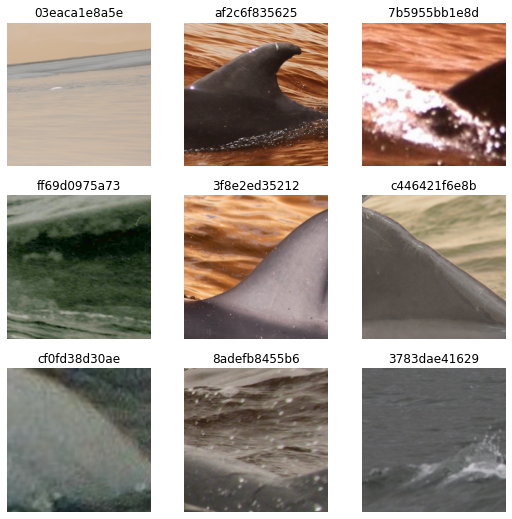

In [20]:
dls.show_batch()

In [21]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)

CPU times: user 13.1 s, sys: 6.51 s, total: 19.6 s
Wall time: 1min 25s


/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.001737800776027143)

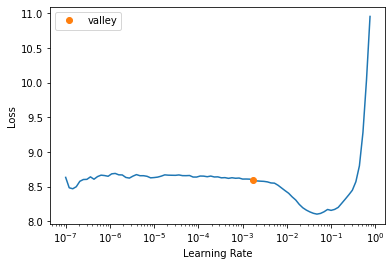

In [17]:
%%time

learn.lr_find()

In [22]:
%%time
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,8.706921,7.703584,1.000000,00:16
1,8.609007,7.426311,1.000000,00:15
2,8.365679,7.282722,1.000000,00:15
3,7.912194,7.137839,1.000000,00:15
4,7.500206,7.022965,0.966667,00:15
5,7.037305,6.848432,0.966667,00:16
6,6.705000,6.747540,0.966667,00:15
7,6.396744,6.740534,0.966667,00:15
8,6.112604,6.715089,0.966667,00:15
9,5.910398,6.716238,0.966667,00:15


CPU times: user 19.8 s, sys: 16.7 s, total: 36.5 s
Wall time: 2min 35s


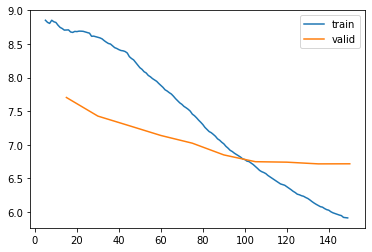

In [23]:
learn.recorder.plot_loss()

In [24]:
import cal_MAP5

In [25]:
preds, actual = learn.get_preds()

In [26]:
preds_sorted = []
for i in preds :
    temp = list(np.argsort(-i)[:5])
    preds_sorted.append(temp)

In [27]:
len(actual), len(preds_sorted)

(30, 30)

In [28]:
cal_MAP5.map_per_set(preds_sorted, actual)

0.05

In [29]:
whales = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_x = ColReader('image', pref = path),
                   get_y = ColReader('individual_id'),
                   splitter = ColSplitter('is_valid'),
                   item_tfms = Resize(440))

In [30]:
dls = whales.dataloaders(df_merged)

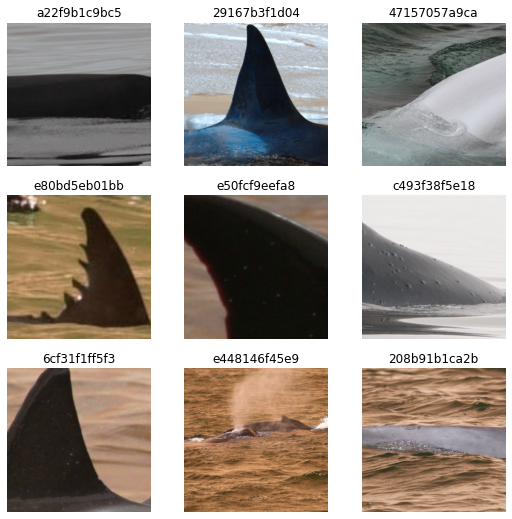

In [31]:
dls.show_batch()

In [32]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)

In [33]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,8.780619,7.547227,1.000000,00:17
1,8.607244,7.214852,1.000000,00:17
2,8.190483,6.940402,0.966667,00:16
3,7.616741,6.495995,0.966667,00:17
4,7.027337,6.302007,0.966667,00:16
5,6.417783,6.081138,0.966667,00:17
6,5.897161,5.991110,0.933333,00:16
7,5.459887,5.941291,0.933333,00:17
8,5.128700,5.945453,0.933333,00:17
9,4.892064,5.945018,0.933333,00:17


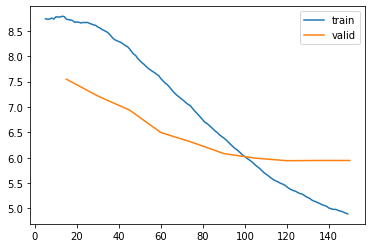

In [34]:
learn.recorder.plot_loss()

In [35]:
preds, actual = learn.get_preds()

In [36]:
preds_sorted = []
for i in preds :
    temp = list(np.argsort(-i)[:5])
    preds_sorted.append(temp)

In [37]:
cal_MAP5.map_per_set(preds_sorted, actual)

0.125

In [38]:
preds, actual = learn.get_preds(ds_idx = 0)

In [39]:
len(actual)

970

In [40]:
preds_sorted = []
for i in preds :
    temp = list(np.argsort(-i)[:5])
    preds_sorted.append(temp)

In [41]:
cal_MAP5.map_per_set(preds_sorted, actual)

0.7138144329896908

In [42]:
torch.cuda.empty_cache()